In [1]:
#built in librairies 
from tqdm import tqdm

# pip libraires
import numpy as np
import json
import pandas as pd


# visualization librairies
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

# Natural Language Processing Librairies
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import re

# Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Calculating libraries
import scipy as sp

#statistical librairies
import pingouin 

# Import libraries
import requests
from bs4 import BeautifulSoup


#from genres import genre_wordsets
import csv
import datetime  
from dateutil.relativedelta import relativedelta
from utils.genres import additional_wordsets


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/bastienll/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bastienll/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/bastienll/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Our dataset contains different datasets. We have:
- Metadata
- Plots of Movies
- Characters 


# Metadata

In [3]:
metadata = pd.read_table('./data/movie.metadata.tsv',header=None)
metadata.columns = ["wiki_id","freebase_id","movie_name","release_date","box_office","duration","language","country","genre"]
ratings = pd.read_csv('./data/title.ratings.tsv', sep = "\t")
titles = pd.read_csv('./data/title.basics.tsv', sep = "\t")


/tmp/ipykernel_20835/3875867614.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv('./data/title.basics.tsv', sep = "\t")


In [4]:
titles = pd.merge(titles, ratings, on = 'tconst')
titles = titles[['primaryTitle','originalTitle','averageRating', 'startYear']]
titles['Movie_release_year'] = pd.to_datetime(titles['startYear'], errors = 'coerce').dt.year
metadata['Movie_release_year'] = pd.to_datetime(metadata['release_date'], errors= 'coerce').dt.year
titles = titles.rename(columns = {'primaryTitle': 'movie_name'})
titles = titles.groupby('movie_name').mean()
titles.reset_index(inplace = True)
metadata = pd.merge(metadata, titles, on = ['movie_name', 'Movie_release_year']).drop(['Movie_release_year'], axis = 1)

In [5]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28916 entries, 0 to 28915
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wiki_id        28916 non-null  int64  
 1   freebase_id    28916 non-null  object 
 2   movie_name     28916 non-null  object 
 3   release_date   28916 non-null  object 
 4   box_office     2883 non-null   float64
 5   duration       23519 non-null  float64
 6   language       28916 non-null  object 
 7   country        28916 non-null  object 
 8   genre          28916 non-null  object 
 9   averageRating  28916 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 2.4+ MB


Here are our observations:
- Box Office contains mainly null values, so we drop the column.
- The type of the release_date is an object, we will transform it into a datetime to make sampling easier.

In [6]:
metadata.drop(columns="box_office",inplace=True)
metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors = 'coerce')


In [7]:
metadata.head(1)

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre,averageRating
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",6.4


We note that language, country, genre are JSONs. Therefore, we nede to transform them into a list

In [8]:
json_cols = ["language","country","genre"]
for col in json_cols:
    metadata[col] = metadata[col].apply(lambda x:list(json.loads(x).values()))

In [9]:
metadata.head()

,wiki_id,freebase_id,movie_name,release_date,duration,language,country,genre,averageRating
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",6.4
1,28463795,/m/0crgdbh,Brun bitter,1988-01-01,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",5.7
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,106.0,[German Language],[Germany],[Drama],6.0
3,175026,/m/017n1p,Sarah and Son,1930-01-01,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",5.4
4,24229100,/m/07kjkz6,Lady Snowblood 2: Love Song of Vengeance,1974-01-01,89.0,[Japanese Language],[Japan],"[Crime Fiction, Thriller, Japanese Movies, Wor...",6.3


In [10]:
ProfileReport(metadata)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### need to make a description of the report

We are aware that the columns can contain list with one value at a time. For simplicity of cleaning, we leave it llike that for the moment.

In [11]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


In [12]:
genres =pd.Series(flatten_list(list(metadata.genre)))
n_genres = len(set(genres))
print("Number of genres: {} ".format(n_genres))

Number of genres: 338 


We have 363 genres. Some of them are quite specific : Homoeroticism,Silhouette animation and other are more general.
In order to have a deeper analysis for the genres, we need to link every genre into a metagenre. 

Therefore, we have created a mapping to the 363 genres to broader meta-genres.

## Metagenre classification
### Natural Language Processing (NLP) : Stemming ###
The first step is to create some Natural Language Processing and cleaning functions. 

The first function allows us to stem a string, by doing this we can classify all similar words with the same *root*. A lot of the genres in the dataset are variations of the same word and genre. By extracting the body of the word, these variations are considered the same and will be classified together. Some examples of this principle can be seen in the following table, where two similar genres are put together :

| Genre 1 | Genre 2 | Root    | Metagenre |
|-------|-------|-------|-------|
| Biography | Biographical   | Biograph | History
| Romantic | Romantical | Rom | Romance

We decided to use one of the most aggressive stemmers - the Lancaster Stemmer - as it gave the best results compared to other stemmers (Porter stemmer or Snowball stemmer) that often had classification problems. Lemmatizers were also considered, however we also found errors in classification.

| Algorithm | Genre 1 | Root 1 | Genre 2 | Root 2 | Metagenre |
|-------|-------|-------|-------|-------|-------|
| Lancaster Stemmer | Historical   | Hist | History | Hist | History
| Porter Stemmer | Historical   | Histor | History | Histori | History
| Snowball Stemmer | Historical   | Histor | History | Histori | History
| WordNet Lemmatizer | Historical   | Historical | History | History | History

As we can see the Lancaster stemmer gives us the desired result.

In [ ]:
def stem_string(x:str)->list:
    """ Returns the stem of every word in the input

    Args:
        x (str): Contains the input to be stemmed

    Returns:
        list: a list of the words stemmed
    """
    
    # Create a stemmer, the Lancaster Stemmer is used here
    stemmer = LancasterStemmer()

    # Tokenize the string --> separate words in a list, separating punctuation as well
    words = word_tokenize(x)

    # Stem every word in the tokenized list
    stemmed_words = [stemmer.stem(word) for word in words]

    # Return a list of Stemmed words
    return stemmed_words


### Natural Language Processing (NLP) : String Cleaning ###

The second part of our genre processing is cleaning the data. Basic NLP cleaning is used : lower characters only, use only alphabetic characters and dash, remove double spaces. 

We however decided to formalize two genres : black-and-white and science-fiction. Making sure that there two genres are written with a dash ('-') this allows us to later compare the word as a whole.

In [ ]:
def clean_string(str:str)->str:
    """
    This function cleans the input string using basic NLP and Regex 

    Args:
        str (string): input string 

    Returns:
        string: a cleaned formalized string
    """
    # Make all characters lower caps
    clean_s = str.lower()

    # Transforms all spaces to dashes if they are followed by the word "white". Used to formalize black-and-white
    clean_s = re.sub(r'-(?!.*(white))', ' ', clean_s)

    # Transforms all spaces to dashes if they are followed by the word "fi" and preceded by "sci",
    #  or followed by the word "fiction" and preceded by "science". Used to formalize "sci-fi" and "science-fiction"

    clean_s = re.sub(r'((?<=sci) (?=fi))|((?<=science) (?=fiction))', '-', clean_s)

    # remove everything except alphabets and dashes
    clean_s = re.sub("[^a-zA-Z-]"," ",clean_s) 

    # remove double whitespaces 
    clean_s = ' '.join(clean_s.split()) 
    return clean_s


In [ ]:
def clean(var:object):
    """
    This functions detects the input object structure and cleans all strings present.
    Can be called recursively if multiple dimensions exist in the structure
    
    Args:
        var (object): input string, list or dictionary

    Returns:
        object: a cleaned formalized string, list or dictionary
    """
    # Create output variable
    out = ''

    # Detect if input is a list
    if type(var) == list:
        out = var.copy()
        # Clean each string in list
        for i,s in enumerate(var):
            out[i] = clean_string(s)
    else :
        # Detect if input is a dictionary
        if type(var) == dict:
            out = var.copy()
            # Clean each key and value
            for key, value in var.items():
                out[clean_string(key)] = clean(value)
        else:
            # Detect if input is a string
            if type(var) == str:
                # Clean string
                out = clean_string(var)
            
            # Raise an exception if input is not a string, list or dictionary
            else:
                raise Exception("Wrong input type for cleaning ! ")

    return out

### Metagenre and subgenre definition ###


In order to create a dictionary with every Metagengre and it's corresponding subgenres, we decided to extract data from the web, specifically the genre list of *studio blinder*. The following website was chosen as it had a good HTML structure and rich information about movie genres and subgenres, as well as being a trusty platform for movie production.

In [ ]:
# Website URL
URL = 'https://www.studiobinder.com/blog/movie-genres-list/'

# Make the request for the website
r = requests.get(URL)


In [ ]:
# Initialise BeautifulSoup for easy HTML analysis
soup = BeautifulSoup(r.text, 'html.parser')

# Extract the HTML wrappers for the major genres
metagenre_wrappers = soup.find_all('div', {"data-css": ["tve-u-16d41491117", "tve-u-16d41ed6dc1", "tve-u-17317362207"]})

# Print the number of metagenres in the website
print('Total number of items: {0}'.format(len(metagenre_wrappers)))

genres = dict([])

# Loop through all the metagenres wrappers, except the last one as it contains other genres that we decided not to add
for p in metagenre_wrappers[:-1]:    
    # Extract all subgenres
    sub_g = p.find_all('h5')
    # Extract metagenre name
    major_genres = p.find_all('h3')

    for g in major_genres :
        # (extract only first word since all metagenres strings are followed by the unwanted word "genre"
        m_genre = clean(g.string.rsplit(' ', 1)[0])
        # For each major genre, create a disctionary entry with the genre keyword 
        genres[m_genre] = []

    for s in sub_g :
        # Add each subgenre to the corresponding metagenre entry
        genres[m_genre].append(clean(str(s.string)))

# Print the results
print("The extracted metagenres and subgenres are : " )
[print(key,':',value) for key, value in genres.items()];

Total number of items: 14
The extracted metagenres and subgenres are : 
action : ['heroic bloodshed', 'military action', 'espionage', 'wuxia action', 'disaster', 'adventure', 'superhero']
animation : ['traditional', 'stop motion', 'claymation', 'cutout', 'computer generated imagery', 'puppetry', 'live action']
comedy : ['action comedy', 'dark comedy black comedy', 'romantic comedy', 'buddy comedy', 'road comedy', 'slapstick comedy', 'parody', 'spoof', 'satire', 'sitcom', 'sketch comedy', 'mockumentary', 'prank']
crime : ['caper', 'heist', 'gangster', 'cop police', 'detective', 'courtroom', 'procedural']
drama : ['melodrama', 'teen drama', 'philosophical drama', 'medical drama', 'legal drama', 'political drama', 'anthropological drama', 'religious drama', 'docudrama']
experimental : ['surrealist', 'absurdist']
fantasy : ['contemporary fantasy', 'urban fantasy', 'dark fantasy', 'high fantasy', 'myth']
historical : ['historical event', 'biography', 'historical epic', 'historical fiction',

### Genre cleaning ###

A lot of genres present in the dictionaries are confusing and will cause wrong classification. when compared later on with the dataset genres. Think for example of the genre "*romance drama*" under *romance* or "*epic western*" under *western*. Since we compare genres word by word, we would only like to have the corresponding keyword so "romance" and "western", since drama will be present either way in the drama metagenre and the word "epic" is applicable to multiple genres not only western. This rule is true for most subgenres : if the metagenre word is present, then the other word is a vague genre applicable to the other metagenres as well (Epic, Urban, etc.) and must be removed.

In [ ]:
def clean_confusing_genres(all_genres:dict)->None:
    """
    This functions removes all the confusing genres from the dictionary.
    
    Args:
        all_genres (dict): input dictionary

    """
    # Create a list with all the stemmed metagenres
    key_list = list(all_genres.keys())
    key_list = [stem_string(key) for key in key_list]

    # Iterate through all the metagenres and their subgenres
    for major_genres, sub_genres in all_genres.items() :
        
        stemmed_major_genre = stem_string(major_genres)
        tmp = sub_genres.copy()

        for s_g in tmp :
            
            if (stemmed_major_genre[0] in s_g) and len(s_g) >= 2 :
                sub_genres.remove(s_g)

            # Revome the word "film" from every subgenre.
            if "film" in s_g :
                s_g.remove("film")
            
            # Revome the word "fiction" from every subgenre.
            if "fict" in s_g :
                s_g.remove("fict")

            #  Revome the subgenre "military" from the "science-fiction" metagenre.
            if "milit" in s_g and stemmed_major_genre[0] == "science-fiction":
                s_g.remove("milit")
        
        # Add as a subgenre the corresponding metagenre
        all_genres[major_genres].append(stemmed_major_genre) 
        
        # Clean the genre dictionary, mainly removing empty lists   
        all_genres[major_genres] = [x for x in sub_genres if x]

Even if the studio binder website contains multiple metagenres, we would like to add our own genres and subgenres in order to have better classification as well as other inicators for our analysis such as "propaganda" and "diversity" metagenres. We therefore import our own genre dictionary.

In [ ]:
from utils.genres import additional_wordsets

In [ ]:
def mergeDictionary(dict_1:dict, dict_2:dict)->dict:
    """
    This functions removes all the confusing genres from the dictionary.
    
    Args:
        dict_1 (dict): first input dictionary to merge
        dict_2 (dict): second input dictionary to merge

    Returns:
        dict: merged dictionary

    """
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def stem_dictionary(dict:dict) -> None:
    """
    This functions stems all values in a dictionary.
    
    Args:
        dict (dict): input dictionary to stem
    """
    # Stems every string in the dictionary values
    for key, values in dict.items() :
        dict[key] = [stem_string(v) for v in values]

In [ ]:
# Create final genre dictionary with web and local genres
genre_map = mergeDictionary(genres, clean(additional_wordsets))
stem_dictionary(genre_map)
clean_confusing_genres(genre_map)

# Display final Dictionary used for classification
[print(key,':',value) for key, value in genre_map.items()];

action : [['swashbuckl'], ['comb'], ['mart'], ['box'], ['sword'], ['hero', 'bloodsh'], ['esp'], ['disast'], ['adv'], ['superhero'], ['act']]
animation : [['cartoon'], ['tradit'], ['stop', 'mot'], ['claym'], ['cutout'], ['comput', 'gen', 'imagery'], ['puppetry'], ['liv', 'act'], ['anim']]
comedy : [['slapstick'], ['tragicomedy'], ['ston'], ['sketch'], ['parody'], ['spoof'], ['satir'], ['sitcom'], ['mocku'], ['prank'], ['comedy']]
crime : [['spy'], ['crimin'], ['prison'], ['slash'], ['whodunit'], ['crimin'], ['cap'], ['heist'], ['gangst'], ['cop', 'pol'], ['detect'], ['courtroom'], ['proc'], ['crim']]
drama : [['tragicomedy'], ['american'], ['tragedy'], ['melodram'], ['docudram'], ['dram']]
experimental : [['indy'], ['short'], ['art'], ['sur'], ['absurd'], ['expery']]
fantasy : [['supern'], ['myth'], ['fantasy']]
historical : [['hist'], ['hist'], ['biop'], ['biograph'], ['biograph'], ['period', 'piec'], ['hist']]
horror : [['haunt'], ['ghost'], ['monst'], ['werewolf'], ['vampir'], ['occu

In [ ]:
def extract_genres(df_genres:list)->list:
    """ 
    finds all the metagenres from the movie genre list, referring to the the genre_map 

    Args:
        df_genres (list): list of subgenres

    Returns:
        list: list of metagenres
    """
    genre_list = []
    input_genres = df_genres.copy()

    # Clean and concatenate all genres in the input
    merged_stem_strings = [stem_string(clean(g)) for g in input_genres]

    # For each major genre and subgenre in the genre map, check if they are in the input
    for major_genres, sub_genres in genre_map.items() : 
        for s_g in sub_genres :
            for item in merged_stem_strings :
                if s_g[0] in item :
                    genre_list.append(major_genres)

    # If no metagenre was found, classify movie as "other"
    if len(genre_list) == 0 :
        genre_list.append("Other")

    # Remove metagenre duplicates
    genre_list = list(set(genre_list))

    return genre_list

## Metagenres

In [22]:
metadata["metagenre"]=metadata["genre"].apply(extract_genres)

We will present an analysis for evolution of metagenres throughout the time in the Analysis Section.

# Movie Plots

In [23]:
# read plots
plots = []
with open("data/plot_summaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab') 
    for row in tqdm(reader):
        plots.append(row)

movie_id = []
plot = []


42303it [00:00, 65618.36it/s]


In [24]:
# extract movie Ids and plot summaries
for i in tqdm(plots):
    movie_id.append(i[0])
    plot.append(i[1])


100%|██████████| 42303/42303 [00:00<00:00, 602519.13it/s]


In [25]:
# create dataframe
plots = pd.DataFrame({'movie_id': movie_id, 'plot': plot})


In [26]:
def clean_text(text):
    # remove a string like {{plot}}
    text = re.sub("\s*{{\w*}}\s*", "", text)
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text)
    
    text = text.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0',' ') #get rid of problem chars
    
    text = ' '.join(text.split())
    
    return text

plots['plot'] = plots['plot'].apply(clean_text)


In [27]:
plots.sample(10)

,movie_id,plot
6623,5162931,"while walking her guard rounds in the country,..."
15842,15234647,{{expand section}} billy zanes unnamed charact...
41357,217824,"tina balser, an educated, frustrated housewife..."
8897,33913958,sang-hyun and dong-hyun were born as conjoined...
18609,22858261,union newsreel reporter chris hunter is sneaki...
7947,9962683,somna lives a poor lifestyle with her widowed ...
11242,16457387,set in the edwardian era music halls of london...
26229,8644317,lonnie earl dodd is a little rock car dealer w...
30991,1213595,"deep in the south american jungle, a japanese ..."
27796,13831741,"a gang of mercenaries, led by marcus cutter, s..."


The plots dataset contains a little over 42000 summaries of movies, each linked to a movie through an ID

# Characters

In [28]:
characters = pd.read_csv("data/character.metadata.tsv", sep = '\t', header = None)


In [29]:
characters.columns = ["wiki_movie_id","freebase_movie_id","release_date","character_name","date_birth","gender",
                      "height","ethnicity","act_name","act_age",
                      "freebase_char_actor_id","freebase_char_id","freebase_actor_id"]

In [30]:
characters.head(1)

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7


We observe that the release_date and date_birth are dates and we therefore transform them to datetime to be able to handle them more simply

In [31]:
characters.release_date = pd.to_datetime(characters.release_date, errors = 'coerce')
characters.date_birth =  pd.to_datetime(characters.date_birth , errors = 'coerce')

In [32]:
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,date_birth,gender,height,ethnicity,act_name,act_age,freebase_char_actor_id,freebase_char_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


We see in the first lines a few Nan and therefore it is worth to verify how much data is missing

In [33]:
characters.isna().sum(axis=0)


wiki_movie_id                  0
freebase_movie_id              0
release_date               10010
character_name            257875
date_birth                106168
gender                     45609
height                    295845
ethnicity                 344611
act_name                    1228
act_age                   158113
freebase_char_actor_id         0
freebase_char_id          257865
freebase_actor_id            815
dtype: int64

In [34]:
print('we observe there is 344611 na values in ethnicity (one of our data of interest), however this only represent {0}  as there many character in most films and we have here many films.'.format(characters.ethnicity.isna().sum()/characters.size))

we observe there is 344611 na values in ethnicity (one of our data of interest), however this only represent 0.05882041689474639  as there many character in most films and we have here many films.


## Historical events

In [35]:
event = pd.read_csv('./data/events.txt', header = None)
event.rename(columns={0:'event', 1:'begin_date', 2:'end_or_popularisation_date', 3:'type_of_event'}, inplace= True)
event['begin_date'] = pd.to_datetime(event['begin_date'], errors = 'coerce' , format = '%Y')
event['end_or_popularisation_date'] = pd.to_datetime(event['end_or_popularisation_date'], errors = 'coerce' , format = '%Y')

In [36]:
event.head()

,event,begin_date,end_or_popularisation_date,type_of_event
0,WW1,1914-01-01,1918-01-01,war
1,russian communist revolution,1917-01-01,1917-01-01,war
2,economic depression,1929-01-01,1929-01-01,economic
3,rise of dictatorships,1920-01-01,1940-01-01,politic
4,WW2,1939-01-01,1945-01-01,war


a list of major historical events built from wikipedia article and our own knowledge

# Analysis

## Evolution of genres throughout the year

In [37]:
metadata.columns

Index(['wiki_id', 'freebase_id', 'movie_name', 'release_date', 'duration',
       'language', 'country', 'genre', 'averageRating', 'metagenre'],
      dtype='object')

In [38]:
dummies_genres = pd.get_dummies(metadata["metagenre"].explode()).sum(level=0)
metadata = metadata.join(dummies_genres)

/tmp/ipykernel_20835/554888437.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies_genres = pd.get_dummies(metadata["metagenre"].explode()).sum(level=0)


In [78]:
cols_to_drop = ["movie_name","duration","language","country","genre","metagenre","wiki_id","averageRating"]

genre_per_date = metadata.copy().drop(columns=cols_to_drop).set_index("release_date")
genre_per_date = genre_per_date.groupby("release_date").sum()
genre_per_date

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1889-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1890-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1891-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1892-10-28,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-06-27,0,1,1,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-07-31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-18,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
genre_per_date.head()

,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,horror,musical,propaganda,religious,romance,science-fiction,silent,thriller,war,western
release_date,,,,,,,,,,,,,,,,,,,,,
1888-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1889-01-01,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1890-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
1891-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1892-10-28,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


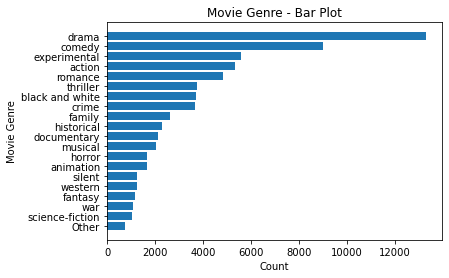

In [80]:
fig, ax = plt.subplots()
n_top_genres = 20 
sorted_genres = genre_per_date.sum(axis=0).sort_values(ascending=False)[:n_top_genres]

ax.barh(sorted_genres.index, sorted_genres.values, align='center')
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_ylabel('Movie Genre')
ax.set_title('Movie Genre - Bar Plot')

plt.show()


We can note that genre, comedy and experimental are part of the top three genres. But what about their evolution throughout time?

In [81]:
# sample per period
window = "5Y"

# chose agg funct from aggfunct = [np.sum,np.cumsum]
cumfunc = None

# normalize every period (sum of the row = 1)
normalize = True

# study the pct_change
pct_change_bool = True


In [82]:
def plot_line(df):
    """function to create interactive plots using plotly_express

    Args:
        df (pd.dataframe): a dataframe having a datetime as index
    """
    fig = px.line(df)

    period = [1,3,5,10,20,30,50,100]
    # Create the financial buttons
    fin_buttons = [  {'count': y, 'label': str(y)+ "YTD", 'step': "year", 'stepmode': "todate"} for y in period ]

    # Create the date range buttons & show the plot
    fig.update_layout({'xaxis': {'rangeselector': {'buttons': fin_buttons}}})
    fig.show()

In [83]:
def genre_per_period(window:str,normalize:bool,pct_change_bool:bool,cumfunc=None):
    """
        genre per period resamples on a certain time windows, and transforms the data to either normalize,
        to mesure the change compared to previous year or to get the cumulative distribution
    Args:
        window (str): the time window we wish to sample the data
        normalize (bool): normalization or not
        pct_change_bool (bool): outputs the percentage of change of the data 
        cumfunc (_type_, optional): cumulative function or not. Defaults to None.

    Returns:
        DataFrame: the result is a newly sampled dataframe that has or not gone through the transformation functions.
    """
    res = genre_per_date.resample(window).sum()
    if not cumfunc==None:
        res = res.apply(cumfunc)
    
    if normalize:
        res = res.div(res.sum(axis=1), axis=0)

    if pct_change_bool:
        res = res.pct_change().fillna(0)
    return res


In [84]:
df= genre_per_period(window=window,cumfunc=cumfunc,normalize=normalize,pct_change_bool=pct_change_bool)

In [85]:
df["max"] = df.max(axis=1)
df["name_max"] = df.idxmax(axis=1)
df.replace([np.inf, -np.inf], 0, inplace=True)
df.sort_values(by="max",ascending=False)


,Other,action,animation,black and white,comedy,crime,diversity,documentary,drama,erotic,...,propaganda,religious,romance,science-fiction,silent,thriller,war,western,max,name_max
release_date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,23.858824,1.392075,7.340789,-1.000000,0.511085,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,23.858824,Other
1943-12-31,0.262949,0.027630,0.010359,-0.020258,-0.114150,-0.046345,-0.747410,2.157373,0.025591,0.010359,...,4.809566,1.020719,-0.275440,0.010359,-1.000000,0.003091,3.877597,-0.152804,4.809566,propaganda
1968-12-31,-0.241838,0.209559,-0.131272,-0.391063,0.008261,0.203408,4.808065,1.042396,-0.144283,0.965806,...,-0.106452,1.680645,-0.100495,0.086748,0.787097,0.119192,-0.159013,0.605078,4.808065,diversity
1958-12-31,1.103069,0.000216,-0.076788,-0.298495,-0.207119,0.101464,-0.263926,0.034483,0.021400,-0.018568,...,-1.000000,0.570292,0.079576,1.476948,0.000000,-0.018568,0.450813,-0.027490,2.397266,horror
1903-12-31,-1.000000,0.000000,0.000000,0.036853,0.922892,0.000000,0.000000,-0.821954,2.204819,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.024620,0.000000,0.602410,-1.000000,2.204819,drama
2003-12-31,-0.207411,-0.144700,0.198186,-0.259287,0.064993,-0.027088,-0.021749,0.339587,-0.027174,-0.092988,...,0.000000,0.363943,0.055670,-0.150155,1.679173,0.033395,-0.121826,-0.330207,1.679173,silent
1938-12-31,-0.372637,0.595684,-0.197344,-0.094622,0.011546,0.294349,-0.163516,0.672968,-0.189317,-0.686318,...,1.509452,-0.372637,0.049787,0.882089,-0.963806,0.321265,-0.042446,1.149052,1.509452,propaganda
1973-12-31,0.999064,0.069537,-0.522804,-0.646729,-0.043137,0.005517,0.458374,-0.083091,0.191700,0.518351,...,-1.000000,0.375700,0.064231,-0.197508,-1.000000,0.215872,-0.322898,-0.190269,0.999064,Other
1978-12-31,0.204159,0.088817,0.934857,-0.318193,-0.107295,-0.114751,0.217512,0.211518,0.008030,0.464963,...,0.000000,0.054670,-0.235840,-0.053993,0.000000,-0.001786,-0.296887,-0.494522,0.934857,animation


We here have a dataframe (df) that represents the percentage evolution of the normalized data per genre sampled every 5 years and under, an interactive visualisation of this.

In [86]:
plot_line(genre_per_period(window=window,cumfunc=cumfunc,normalize=normalize,pct_change_bool=pct_change_bool))

In [87]:
def two_trends(event,nb,genre):
    """this is a helper function to help us build some plots with different trends before and after the event

    Args:
        event (dataframe): event is the event dataframe 
        nb (int): this is the number of the event
        genre (str): this is the genre of interest for the plot
    """
    begin = event.iloc[nb,:].begin_date - relativedelta(years=8)
    end = event.iloc[nb,:].begin_date + relativedelta(years=7)
    temp1 = genre_per_date[begin: event.iloc[nb,:].begin_date].resample("2Y").sum()
    temp1['begin'] = '1'
    temp2 = genre_per_date[event.iloc[nb,:].begin_date: end].resample("2Y").sum()
    temp2['begin'] = '0'
    res = pd.concat([temp1,temp2])
    res['time'] = res.index.year
    sns.lmplot(data=res, x='time', y=genre, hue="begin")

## Impact of Wars

In [88]:
metagenres = pd.Series(flatten_list(list(metadata.metagenre)))
n_metagenres = len(set(metagenres))
print("Number of genres: {} ".format(n_metagenres))
print(set(metagenres))

Number of genres: 24 
{'historical', 'war', 'documentary', 'experimental', 'science-fiction', 'black and white', 'comedy', 'religious', 'romance', 'action', 'crime', 'propaganda', 'family', 'erotic', 'western', 'diversity', 'musical', 'Other', 'fantasy', 'horror', 'drama', 'thriller', 'animation', 'silent'}


Do violance make people want to watch violence? 

In [89]:
fig = px.line(genre_per_date.resample("3Y").sum().war, labels= {'value' : 'number of movie per year'}, title = 'war movies during the past centurywith a focus on WW2 period')
fig.add_vrect(x0=pd.to_datetime(1946, format="%Y"), x1=pd.to_datetime(1939, format="%Y"), 
              annotation_text="WW2")

fig.show()

In [90]:
fig = px.line(genre_per_date.resample("3Y").sum().comedy, labels= {'value' : 'number of movie per year'}, title = 'comedy movies during the past centurywith a focus on WW2 period')
fig.add_vrect(x0=pd.to_datetime(1946, format="%Y"), x1=pd.to_datetime(1939, format="%Y"), 
              annotation_text="WW2")

fig.show()

In [91]:
y_event = 1945
window_y = 5


In [92]:
df_test =  genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
df_test.columns = ["Before","After","Drop"]
df_test.fillna(0,inplace=True)
df_test.drop(columns="Drop",inplace=True)
df_test.head()

,Before,After
Other,1.0,14.0
action,47.0,200.0
animation,5.0,97.0
black and white,108.0,410.0
comedy,89.0,408.0


In [93]:
df_modif = df_test.stack().reset_index().rename(columns={"level_0":"genre","level_1":"Before or after",0:"Value"})
df_modif.head()

,genre,Before or after,Value
0,Other,Before,1.0
1,Other,After,14.0
2,action,Before,47.0
3,action,After,200.0
4,animation,Before,5.0


Text(0.5, 1.0, 'boxplot of genre before and after the second world war')

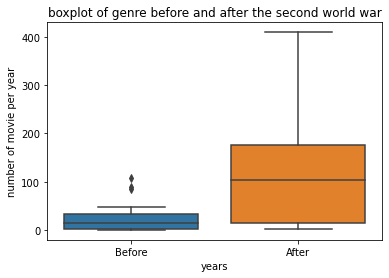

In [94]:
sns.boxplot(data=df_modif, x='Before or after', y='Value')
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('boxplot of genre before and after the second world war')


Text(0.5, 1.0, 'histogramm of genre before and after the second world war')

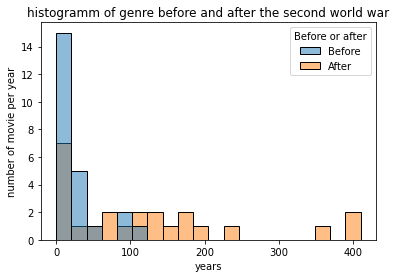

In [95]:
sns.histplot(data=df_modif, hue='Before or after', x='Value',bins=20)
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('histogramm of genre before and after the second world war')

Text(26.794296875000008, 0.5, 'number of movie per year')

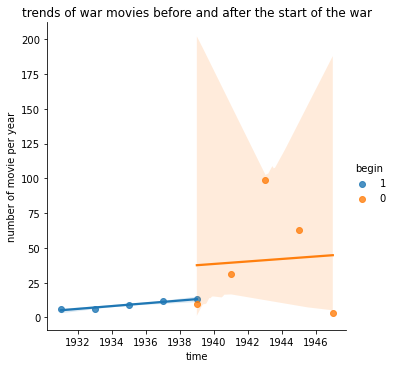

In [96]:
two_trends(event, 4, "war")
plt.title('trends of war movies before and after the start of the war')
plt.ylabel('number of movie per year')

In [97]:
df = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T


In [98]:
df_test =  genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T

In [99]:
pingouin.ttest( x= df_test.iloc[:,0], y= df_test.iloc[:,1],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.075515,23,two-sided,0.000039,"[-140.93, -59.32]",1.097308,636.323,0.999265


Text(0.5, 1.0, 'war movies during the last century')

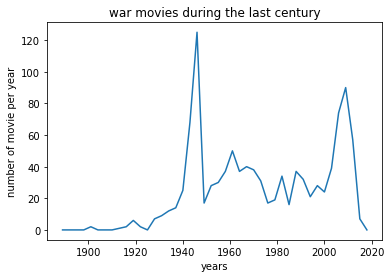

In [100]:
plt.plot(genre_per_date.resample("3Y").sum().war)
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('war movies during the last century')

In [101]:
len(metadata)

28916

In [102]:
metadata.war.sum()

1076

## Impact of technological advances on cinema

we are going to observe how the apparition of color films and sound in cinema impacted this industry.

In [103]:
fig = px.line(genre_per_date.resample("2Y").sum()['black and white'], labels= {'value' : 'number of movie per year'}, title = 'Black and white cinema during the last century')
fig.add_vline(x = pd.to_datetime(1932, format="%Y"))

In [104]:
y_event = 1932

In [105]:
df = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
pingouin.ttest( x= df.iloc[:,0], y= df.iloc[:,1],paired = True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.796718,23,two-sided,0.000931,"[-91.85, -27.06]",0.882921,37.348,0.985323


In [106]:
df.columns = ["Before","After","Drop"]
df.fillna(0,inplace = True)
df.drop(columns = "Drop",inplace = True)
df = df.stack().reset_index().rename(columns = {"level_0":"genre","level_1":"Before or after",0:"Value"})


Text(0.5, 1.0, 'boxplot of genre before and after the creation of color movies')

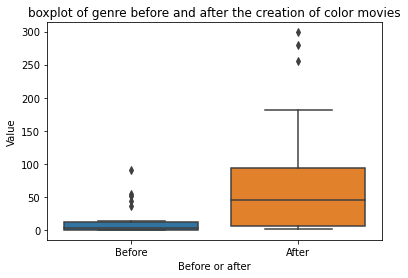

In [107]:
sns.boxplot(data = df,x='Before or after', y='Value')
plt.title('boxplot of genre before and after the creation of color movies')

Text(0.5, 1.0, 'black and white cinema during the last century\n before and after the first film in color')

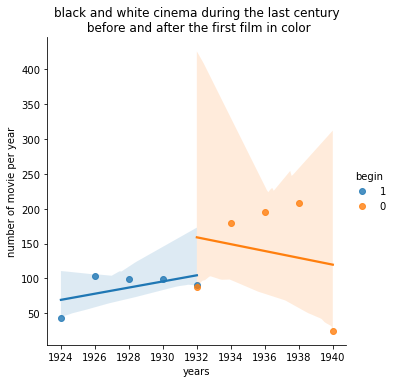

In [108]:
two_trends(event, 12, "black and white")
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('black and white cinema during the last century\n before and after the first film in color')

Text(0.5, 1.0, 'black and white cinema during the last century')

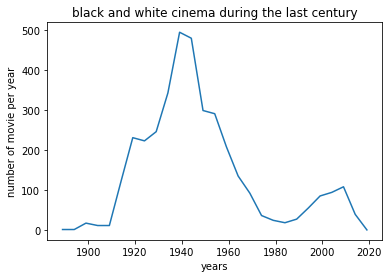

In [109]:
plt.plot(genre_per_date.resample("5Y").sum()['black and white'])
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('black and white cinema during the last century')

In [110]:
fig = px.line(genre_per_date.resample("2Y").sum()['silent'], labels = {'value' : 'number of movie per year'}, title = 'Silent cinema during the last century')
fig.add_vline(x = pd.to_datetime(1927, format="%Y"))
fig.show()

In [111]:
y_event = 1927

In [112]:
df = genre_per_date[str(y_event-window_y):str(y_event+window_y)].resample(str(window_y)+"Y").sum().T
pingouin.ttest( x= df.iloc[:,0], y= df.iloc[:,1],paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.888641,23,two-sided,0.008287,"[-87.17, -14.42]",0.72173,5.672,0.922875


we observe a low p value, and we can therefore say that the distributions are not generated from the same process

In [113]:
df.columns = ["Before","After","Drop"]
df.fillna(0,inplace=True)
df.drop(columns="Drop",inplace=True)
df = df.stack().reset_index().rename(columns={"level_0":"genre","level_1":"Before or after",0:"Value"})


Text(0.5, 1.0, 'boxplot of silent cinema during the last century\n before and after the first film with sound')

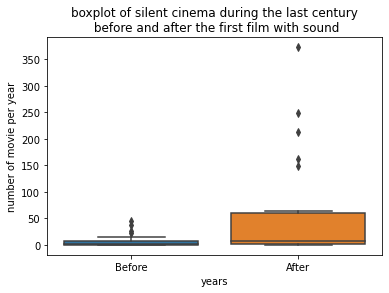

In [114]:
sns.boxplot(data = df,x='Before or after', y='Value')
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('boxplot of silent cinema during the last century\n before and after the first film with sound')

Text(0.5, 1.0, 'silent cinema during the last century\n before and after the first film with sound')

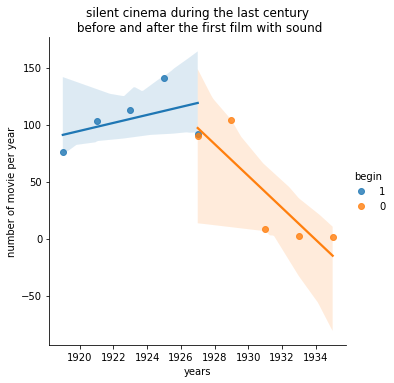

In [115]:
two_trends(event, 10, "silent")
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('silent cinema during the last century\n before and after the first film with sound')

Text(0.5, 1.0, 'silent cinema during the last century')

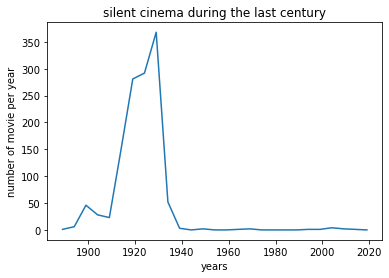

In [116]:
plt.plot(genre_per_date.resample("5Y").sum()['silent'])
plt.ylabel('number of movie per year')
plt.xlabel('years')
plt.title('silent cinema during the last century')

##### Other research on technology/cinema: television, internet netflix etc.